<h2><center>MSIN0097 Predictive Analytics</center></h2><h3><center>Weather Forecasting Time Serie</center></h3>
   

Link to One_Drive: [Here](https://liveuclac-my.sharepoint.com/:f:/g/personal/uceiebu_ucl_ac_uk/EsI5QJaKfUFEsJgSGtDcs9sBQMKEputaRTqlm6zyIAag7A?e=jgAEIk)

<h1>Table of Contents</h1>


* [1. Introduction](#1.-Introduction)
    * [1.1 Business Problem & Question Framing](#1.1-Business-Problem-&-Question-Framing)
* [2. Dataset](#2.-Dataset)
    * [2.1 Loading packages and libraries](#2.1-Loading-packages-and-libraries)
    * [2.2 Dataset Overview](#2.2-Dataset-Overview)
* [3. Data Cleaning & Preparation](#3.-Data-Cleaning-&-Preparation)
* [4. Time Series Analysis](#4.-Time-Series-Analyses)
    * [4.1 Criterions for SARIMA & ARIMA](#4.1-Criterions-for-SARIMA-&-ARIMA)
        * [4.1.a Checking for Stationarity](#4.1.a-Checking-for-Stationarity)
        * [4.1.b Seasonal Decomposition](#4.1.b-Seasonal-Decomposition)
    * [4.2 ARIMA](#4.2-ARIMA)
        * [4.2.a Autocorrelation plot](#4.2.a-Autocorrelation-plot)  
        * [4.2.b Model Fitting](#4.2.b-Model-Fitting)
    * [4.3 SARIMA](#4.3-SARIMA)
        * [4.3.a Faster SARIMA Model](#4.3.a-Faster-SARIMA-Model) 
    * [4.4 Facebook Prophet Model](#4.4-Facebook-Prophet-Model) 
        * [4.4.a Individual components](#4.4.a-Individual-components)
        * [4.4.b Cross validation](#4.4.b-Cross-validation)
* [References](#References)

# 1. Introduction

## 1.1 Business Problem & Question Framing

Climate change is an existential threat to the planet and people around the world. Governments actively seek to reduce their country's impact on the planet yet, being able to predict local temperature is valiable to create solutions for the long term. We will try to use different models to understand if temperature are increasing around Paris.

# 2. Dataset

## 2.1 Loading packages and libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install pmdarima
import pmdarima as pm
from pmdarima import model_selection
import statsmodels.api as sm
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
! pip install pystan==2.19.1.1 --q
! pip install prophet --q
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
import io
from nbformat import current
#Clear console
import warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.
/Users/emericbucaille/opt/anaconda3/lib/python3.8/site-packages/nbformat/current.py:15: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  warnings.warn("""nbformat.current is deprecated.


In [2]:
data = pd.read_csv("raw_data.csv")

## 2.2 Dataset Overview

Our dataset is from the main meteorological statin in Paris (Ile de France) with an altitude of 89m above sea level. 
The coordinates of the station are as followed: latitude 48.716833 and longitude 2.384333. 
The number of the station is: 07149

# 3. Data Cleaning & Preparation

Let us prepare our data for our models.

In [3]:
data.head()

,Unnamed: 0,Date,Pressure at sea level,Dew point,Humidity,Total cloud cover (%),Wind bursts over a period,Temperature,Month number
0,0,2013-04-04 04:00:00+01:00,100750.0,272.85,92.0,90.0,7.7,0.9,4
1,1,2010-01-23 15:00:00+00:00,102000.0,275.95,90.0,100.0,3.6,4.3,1
2,2,2010-01-20 12:00:00+00:00,101070.0,274.05,97.0,100.0,3.6,1.3,1
3,3,2010-01-18 03:00:00+00:00,102710.0,273.55,98.0,40.0,3.1,0.7,1
4,4,2010-01-29 15:00:00+00:00,98690.0,278.15,91.0,100.0,9.8,6.4,1


In [4]:
#Shape of the dataset before cleaning
data.shape

(35016, 9)

In [5]:
#Null values in the dataset
data.isna().sum()

Unnamed: 0                      0
Date                            0
Pressure at sea level           2
Dew point                       1
Humidity                        1
Total cloud cover (%)        1501
Wind bursts over a period      13
Temperature                     1
Month number                    0
dtype: int64

In [6]:
#Creating a secondary dataset for time series analysis
#Since we only require temperature for univariate time series Forecasting, 
#we can extract temp column and date time column from the data
data_temp_ = data[["Date","Temperature"]]

#We will change the Date column data type to datetime
data_temp_['Date'] = pd.to_datetime(data_temp_['Date'])

#It is essential that the data be in order is essential for time series analysis
data_temp_ = data_temp_.sort_values('Date')
data_temp_.head()

#Removing nan values if there is any
data_temp_ = data_temp_.dropna() 

#We will reset the index in the data_temp dataframe
data_temp_.reset_index(drop =True,inplace=True)

#Creating the dataframe with index set to date 
data_temp_ = data_temp_.set_index('Date')

#We make the index datetime as this is crucial for resampling
data_temp_.index = pd.to_datetime(data_temp_.index,utc = True) 

Since we have 8 data points per day for 12 years, we decided to resample the data to one data point per day by taking the daily mean temperature.

In [7]:
data_temp = data_temp_.resample('D').mean()
print(data_temp.shape)

(4384, 1)


In [8]:
data_temp.head()

,Temperature
Date,
2010-01-01 00:00:00+00:00,-0.0625
2010-01-02 00:00:00+00:00,-0.6250
2010-01-03 00:00:00+00:00,-0.4875
2010-01-04 00:00:00+00:00,-4.6750
2010-01-05 00:00:00+00:00,-4.0625


In [9]:
#Removing the time portion
data_temp.index = data_temp.index.date
data_temp

,Temperature
2010-01-01,-0.0625
2010-01-02,-0.6250
2010-01-03,-0.4875
2010-01-04,-4.6750
2010-01-05,-4.0625
...,...
2021-12-28,11.2625
2021-12-29,11.9500
2021-12-30,13.3750
2021-12-31,10.6250


We can quickly visualise our data to make sure there is no flaws or outliers in the data. We will replot this at the start of our Time Series Analyses.

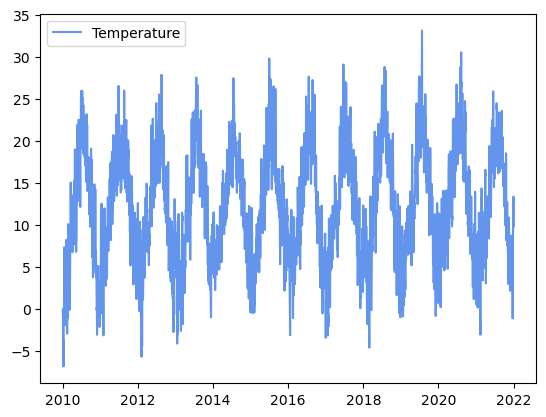

In [10]:
data_temp.plot(color='#6495ed')
plt.show()

In [11]:
#Converting the column to datetime
data["Date"]= data['Date'].astype(str, errors = 'raise')
data['Date'] = data['Date'].str.split(' ')
data['date'] = data['Date'].apply(lambda row: row[0])
data['Time'] = data['Date'].apply(lambda row: row[1].split('+')[0])
data = data.drop(columns=['Date'])
data.rename(columns = {'date':'Date'}, inplace = True)
data['Date'] = pd.to_datetime(data['Date'])

# 4. Time Series Analysis 

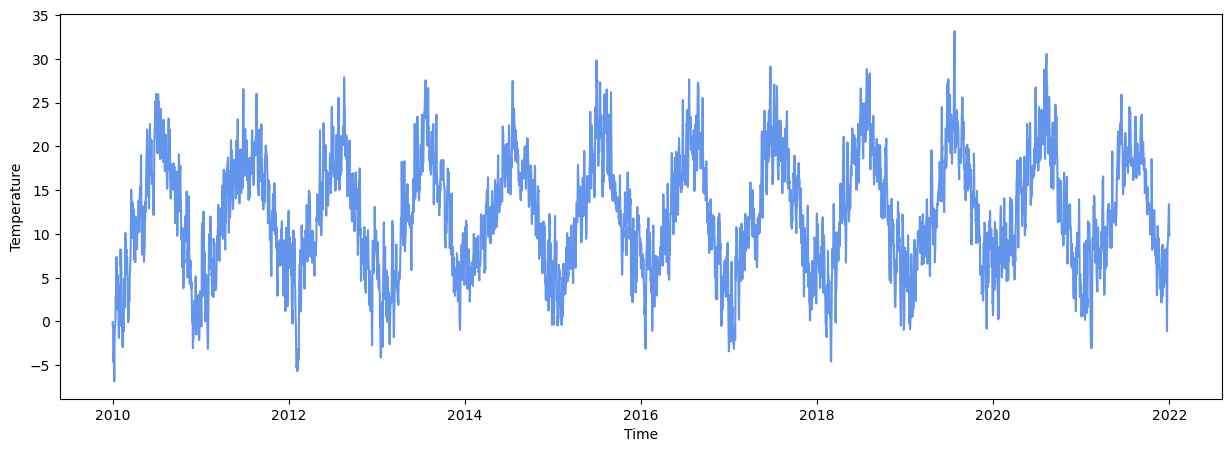

In [12]:
#Lets plot the data again to understand our data
plt.figure(figsize=(15, 5))
plt.plot(data_temp.index,data_temp['Temperature'],color='#6495ed')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

We can confirm that there is a strong seasonality in our data just by visual inspection. We can even see that the season length is roughly one year. This is to be expected since temperature throughout a year changes according to the seasons.  

It is unclear if there is a trend of temperature increase in the data yet we see a particularly high year in 2019. We shall verify later if there is a trend of increase temperature.

## 4.1 Criterions for SARIMA & ARIMA 

There are few assumptions when it comes to an ARIMA Model. To successfull fit the data to the model, we need to make sure the data meets these assumptions.  
* **Stationarity** - Data should be stationary. If not, it should be made stationary. Stationarity simply means the datapoints doesn't depend on the time. More technically, the mean, variance and autocorrelation structure of the data shouldnt change over time. That means we have to account for trends of the data. 
* **Univariate** - For ARIMA, the data should be on a single variables (there are few exceptions with SARIMA) because autoregression is about regression with past values.  
* **Seasonality** - Additionally as previously described, ARIMA cannot work with seasonal data. But, that's where SARIMA excels.



### 4.1.a Checking for Stationarity 

To test the stationarity of the data, we can use the Augmented Dickey Fuller (ADF) Test. Which belongs to a category of Unit Root Test where unit root is prominent if the data is not stationary (Prabhakaran, 2019).

ADF test will give us:
* ADF Statistic
* p - value
* Number of lags used
* Number of observations used  

The important parameter is the p value. H0 (null hypothesis) will state that the data is non stationary and H1 (alternative hypothesis) will state the data is stationary (if p < 0.05, data is stationary).

In [13]:
#Ho: It is non stationary
#H1: It is stationary
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis (Ho), we can reject the null hypothesis. The data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, we don't reject the null hypothesis. The time series has a unit root, indicating it is non-stationary ")
    

In [14]:
adfuller_test(data_temp['Temperature'])

ADF Test Statistic : -4.40813285955829
p-value : 0.000287148214142544
#Lags Used : 18
Number of Observations Used : 4365
Strong evidence against the null hypothesis (Ho), we can reject the null hypothesis. The data has no unit root and is stationary


With this result, we can see that our data is stationary. This implies that **there is no significant trend in temperature thoroughout the years**. Yet, other methods can be use to check stationarity that are more visually appealing like rolling mean and rolling standard deviation.

* **Rolling mean** - Also known as Moving Average, it is an average data with respect to a window size given. The larger the window size, the smoother the data is going to be.

* **Rolling Standard Deviation (std)** - Calculates standard deviation with respect to a given window size.

In [15]:
#Period length which is 365 days because we have a data point for each day
period_length = int(len(data_temp)/12)

As our data is seasonal, we need to provide a specific number of datapoints per season (or a multiple of the value) 
as the rolling window. Otherwise, we will see false trends. Naturally, if the data was not seasonal, this would not be a problem.

In [16]:
print("Number of datapoints per season is: ",period_length)
rolmean=data_temp['Temperature'].rolling(window=period_length).mean() 
rolstd=data_temp['Temperature'].rolling(period_length).std()
print(rolmean.tail(15))
print(rolstd.tail(15))

Number of datapoints per season is:  365
2021-12-18    11.969765
2021-12-19    11.958258
2021-12-20    11.946477
2021-12-21    11.923669
2021-12-22    11.882368
2021-12-23    11.859114
2021-12-24    11.863943
2021-12-25    11.878361
2021-12-26    11.896204
2021-12-27    11.909354
2021-12-28    11.930073
2021-12-29    11.953464
2021-12-30    11.978532
2021-12-31    11.997231
2022-01-01    12.022642
Name: Temperature, dtype: float64
2021-12-18    6.405264
2021-12-19    6.414515
2021-12-20    6.423284
2021-12-21    6.445934
2021-12-22    6.481114
2021-12-23    6.495945
2021-12-24    6.492810
2021-12-25    6.480769
2021-12-26    6.464479
2021-12-27    6.456078
2021-12-28    6.441779
2021-12-29    6.426248
2021-12-30    6.413852
2021-12-31    6.399876
2022-01-01    6.372705
Name: Temperature, dtype: float64


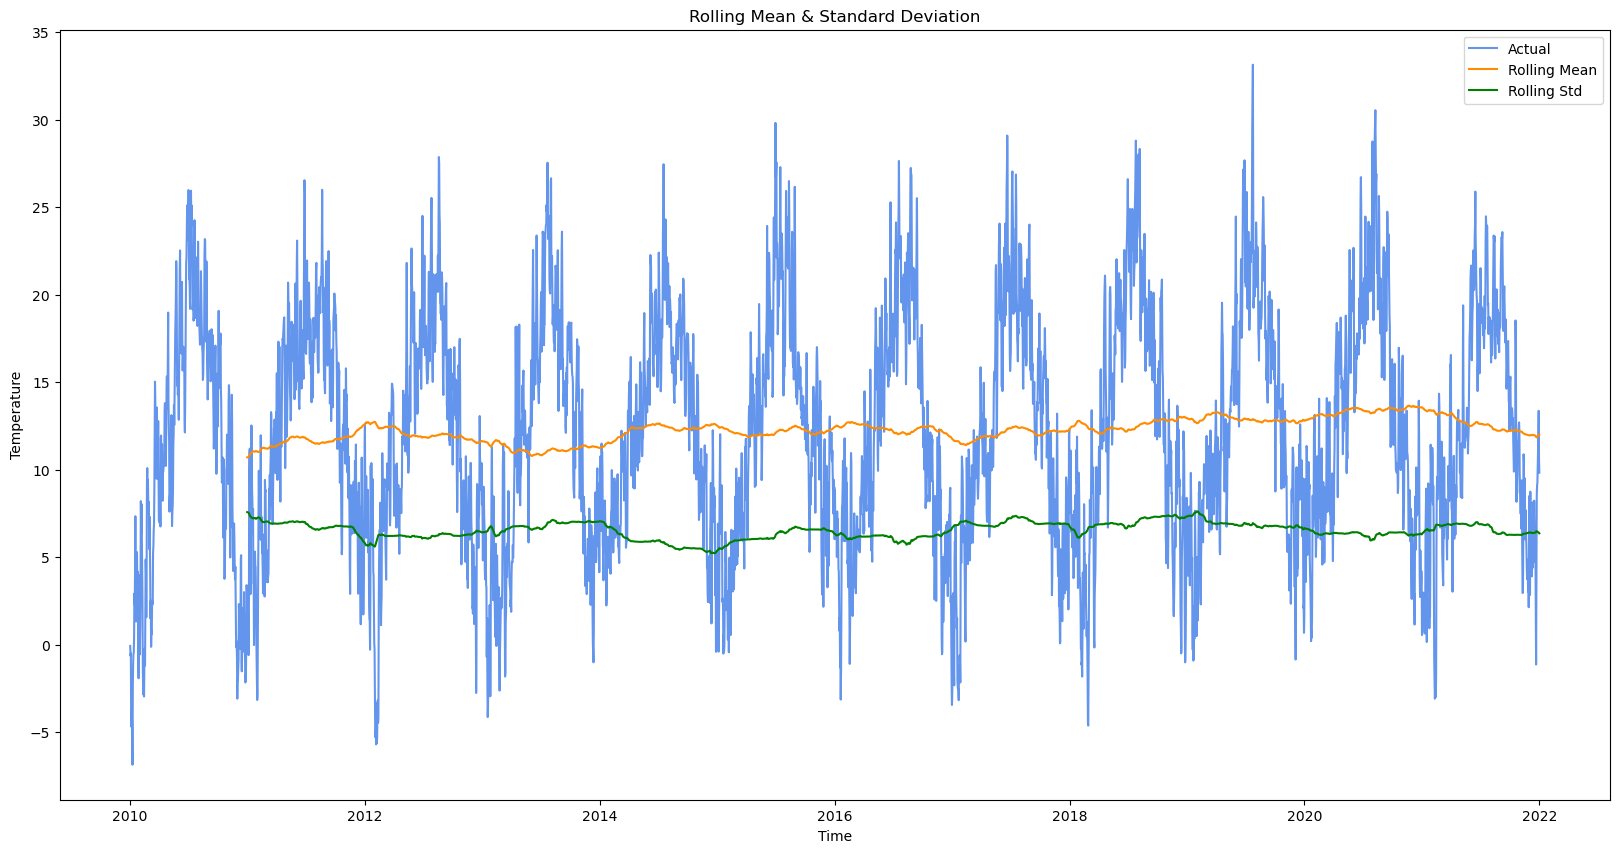

In [17]:
#Visualizing Rolling Mean and Rolling Std
plt.figure(figsize=(20,10))
actual=plt.plot(data_temp.index,data_temp['Temperature'], color='#6495ed', label='Actual')
mean=plt.plot(data_temp.index,rolmean, color='darkorange', label='Rolling Mean') 
std=plt.plot(data_temp.index,rolstd, color='green', label='Rolling Std')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

From our graph, we see no visible trend in the data and the standard deviation is also pretty low. So we can confirm that the data is stationary. If the data was not stationary, I could've used techniques such as,
* Differencing - Substracting the lag data from current data  
* Exponential transformations - Involves getting the log of the data and substracting exponential data from it (Brownlee, 2017) 

### 4.1.b Seasonal Decomposition   
Additionally, we can use statsmodels seasonal_decompose library to Decompose the data into:
  * Trends 
  * Seasonal Components 
  * Residuals - Random fluctuations  

This will help us identify the seasonality in a more technical way.

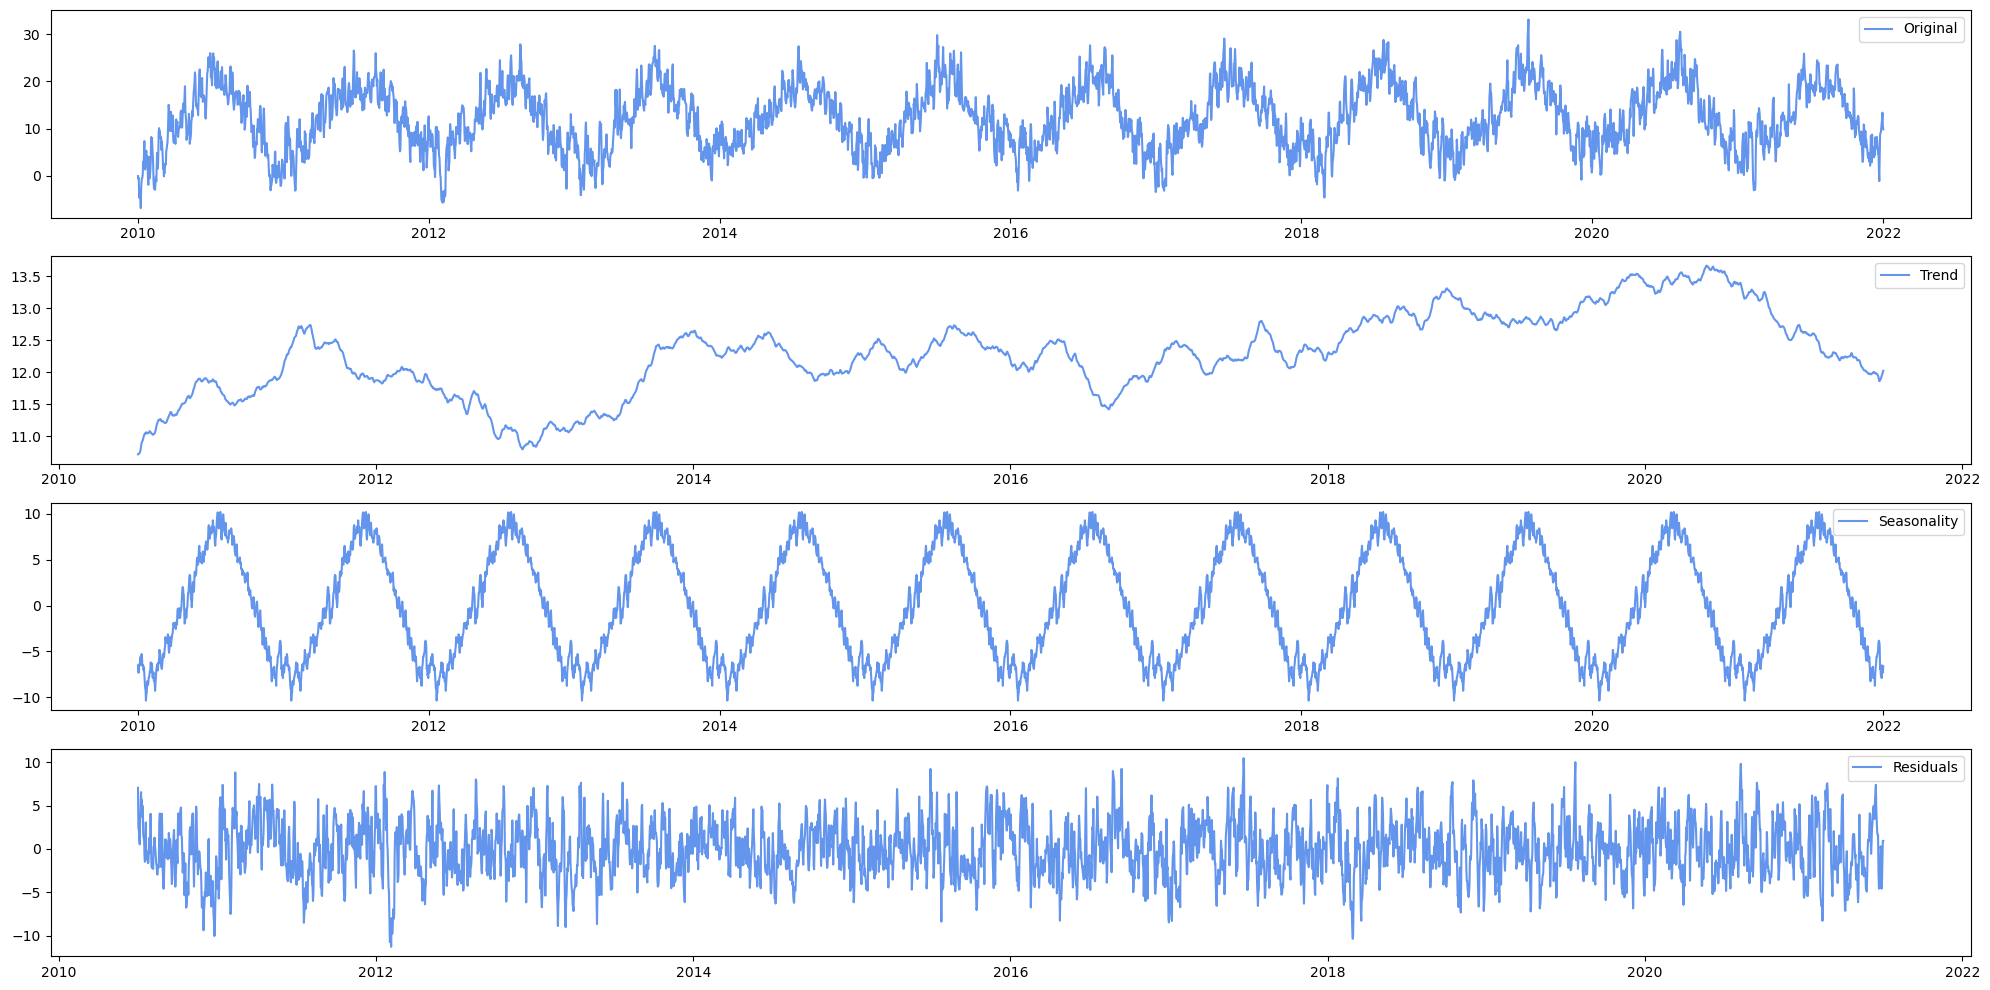

In [18]:
#We need to specify the period which is a year
#Since there are 12 years, we can get that by dividing the length of the dataframe by 12 as an integer
decomp=seasonal_decompose(data_temp, period = int(len(data_temp)/12))
trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid
plt.figure(figsize=(20,10))
plt.subplot(411)
plt.plot(data_temp, label='Original', color ='#6495ed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color ='#6495ed')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color ='#6495ed')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color ='#6495ed')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

With these plots, we can clearly see that there is a clear seasonality, not well defined trend, and lots of random fluctuations in the temperature throughout the years

## 4.2 ARIMA
### Autoregressive Integrated Moving Average Model
First, we thought about using an ARIMA Model to forecast the univariate time series data. 

Due to the Autoregressive nature which is similar to linear regression but uses previous values to predict the future values. 
The moving average part of ARIMA allows to smooth out the data which is going to help to reduce random fluctuations and the integreted part allows to estimate a time series with a trend.  

  
However, the issue with ARIMA is that it cannot handle seasonal data (where data tends to repeat itself periodically). With the previous tests, it is very clear that there is a significant seasonality in the data.  

Nonetheless, I will try the ARIMA Model just to see the effectiveness

There are 3 hyperparameters we need to find before implementing the ARIMA Model,
* **p** - The number of lags included in the AR model (Using autocorrelation plot)
* **d** - The number of times that the raw observations are differenced (Because the data is stationary, we do not difference the data)
* **q** - The size of the moving average window, also called the order of moving average (We haven't used a moving average on data before hence we will set it at 1)

### 4.2.a Autocorrelation plot  
An autocorrelation plot is designed to show whether the elements of a time series are positively correlated, negatively correlated, or independent of each other where verticle axis show the correlation values and the horizontal axis shows the lag between elements in the time series (Anderson, 2016).

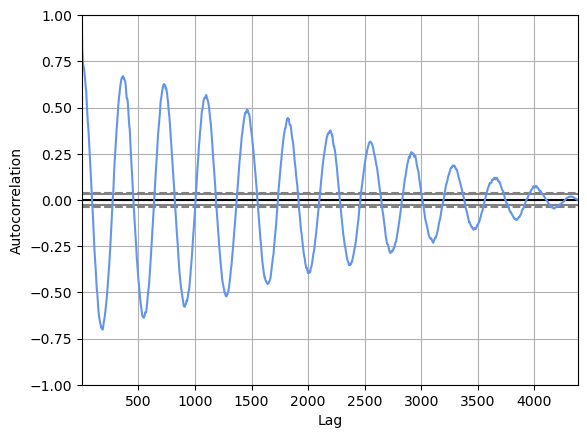

In [19]:
autocorrelation_plot(data_temp, color ='#6495ed')
plt.show()

Here you can see that how the seasonality of data affects the autocorrelation plot (which itself is an AR Model). Which fundamentally show that seasonal data is not suitable for ARIMA Models. We will get the difference between seasons by substracting data shifted by a whole season by the original data and have an accurate value for **p**.

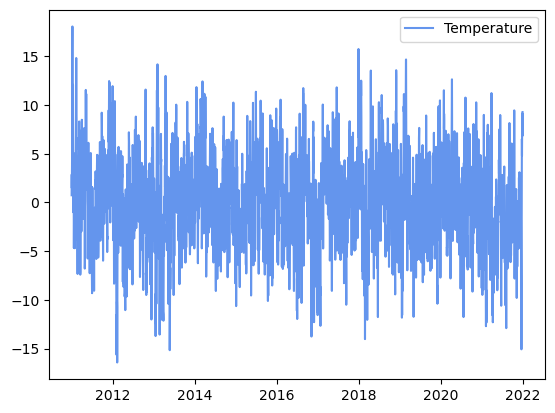

In [20]:
shifted_seasonal = data_temp - data_temp.shift(period_length)
shifted_seasonal.plot(color ='#6495ed')
plt.show()
#Now the seasonality has been removed from the data

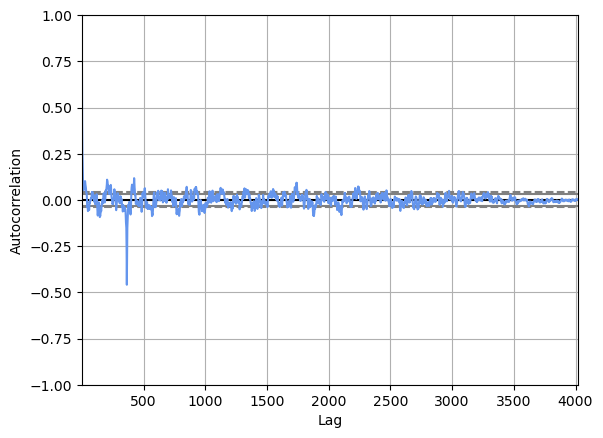

In [21]:
#Since first 2917 values of our dataset is Nan, I will not use those for autocorrelation
autocorrelation_plot(shifted_seasonal.iloc[period_length:], color ='#6495ed')
plt.show()

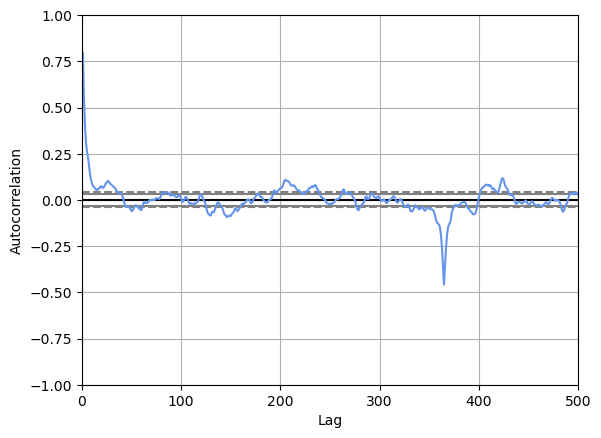

In [22]:
#Zooming in to see the first lags
ax = autocorrelation_plot(shifted_seasonal.iloc[period_length:], color ='#6495ed')
ax.set_xlim([0, 500])
plt.show()

The correlation is very low from the start. The ideal value would be 0.5 yet we will use **a lag value (p) of 1**.

### 4.2.b Model Fitting

In [23]:
#p=1
#d = 0 because we didnt difference the data
#q = 0 or 1

#Implementing ARIMA
ARIMA_model = ARIMA(data_temp['Temperature'],order=(1,0,1))
ARIMA_model = ARIMA_model.fit()

In [24]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Temperature   No. Observations:                 4384
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -9434.255
Date:                Fri, 04 Mar 2022   AIC                          18876.510
Time:                        07:37:51   BIC                          18902.053
Sample:                    01-01-2010   HQIC                         18885.522
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.1677      0.539     22.579      0.000      11.111      13.224
ar.L1          0.9328      0.005    171.912      0.000       0.922       0.943
ma.L1          0.1581      0.015     10.529      0.000       0.129       0.188
sigma2         4.3298      0.090     48.321      0.000       4.154       4.505
===================================================================================
Ljung-Box (L1) (Q):                   1.50   Jarque-Bera (JB):                13.39
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -0.07
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

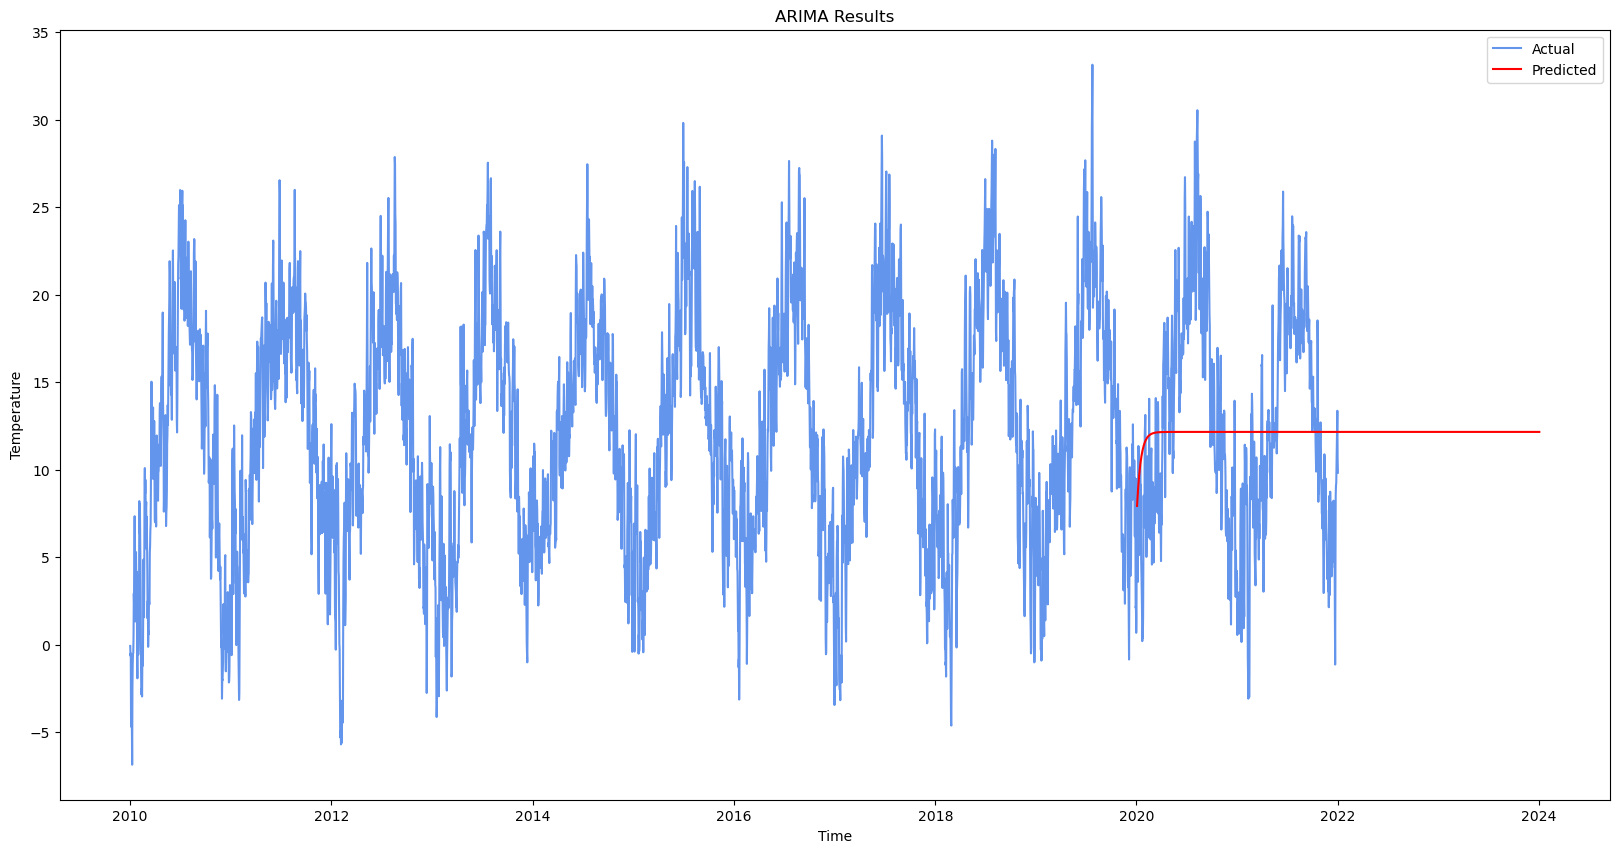

In [25]:
forecast=ARIMA_model.predict(start=len(data_temp)-period_length*2,end=len(data_temp)+period_length*2,dynamic=True)
plt.figure(figsize=(20,10))
plt.plot(data_temp,color = '#6495ed',label = 'Actual')
plt.plot(forecast,color = 'Red',label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend(loc='best')
plt.title('ARIMA Results')
plt.show()

It is clear that ARIMA Model is not accurate for forecasting seasonal data. Eventhough removing the seasonal component will help us get a better ARIMA Model and a prediction, removing the component is pointless as most of the usefull information is contained in the Seasonal Data. 

Therefore, we will construct a SARIMA model.

## 4.3 SARIMA 

SARIMA is an extension of ARIMA which supports Univariate time series data with a seasonal component. It also takes **p, d, q** variables of the ARIMA (which are the trend elements) into consideration. Additionally, SARIMA considers 4 more Seasonal Variables which are,  
* **P** - Seasonal autoregressive order
* **D** - Seasonal difference order
* **Q** - Seasonal moving average order  
* **m** - The number of time steps for a single seasonal period (Which is length of the data divided by number of years - 365)    

Since we already have the trend elements (p,d,q) (1,0,1), **P,D,Q values will be the same as p,d,q**. and the **m will be 365**(Akshay, 2022).
Below, we have commented out the SARIMAX model with 365 seasonality as it takes too much time to process the large seasonal orders. Hence, we have created a faster SARIMAX that resampled data into monthly temperature below.

In [26]:
#Implementation
# model=SARIMAX(data_temp['Temperature'],order=(1, 1, 1),seasonal_order=(1,1,1,period_length))
# results=model.fit()

In [27]:
# forecast_sarimax=results.predict(start=len(data_temp)-period_length*2,end=len(data_temp),dynamic=True)
# plt.figure(figsize=(20,10))
# plt.plot(data_temp,color = 'Yellow',label = 'Actual') 
# plt.plot(forecast_sarimax,color = 'Red',label = 'Predicted')
# plt.xlabel('Time')
# plt.ylabel('Temperature')
# plt.legend(loc='best')
# plt.title('SARIMA Results')
# plt.show()

### 4.3.a Faster SARIMA Model 

In [28]:
data_temp_month = data_temp_.resample('M').mean()
#Removing the time portion
data_temp_month.index = data_temp_month.index.date
print(data_temp_month.shape)
period_length_month = int(len(data_temp_month)/12)
data_temp_month

(145, 1)


,Temperature
2010-01-31,0.627016
2010-02-28,3.724107
2010-03-31,7.270445
2010-04-30,11.395359
2010-05-31,13.056048
...,...
2021-09-30,18.399583
2021-10-31,12.256855
2021-11-30,6.443333
2021-12-31,6.718293


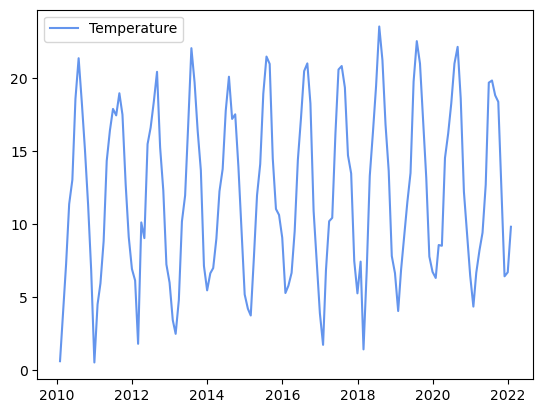

In [29]:
data_temp_month.plot(color ='#6495ed')
plt.show()

In [30]:
#Splitting the data for SARIMAX
def train_test_split(time_series, data_split):
    split_index = int(round(time_series.shape[0]*data_split, 0))
    train_set = time_series[:split_index]
    test_set = time_series[:-split_index]
    return train_set, test_set

training_set, test_set = train_test_split(time_series = data_temp_month['Temperature'], 
                                                      data_split = .75)

We use grid search to explore multiple combinations of parameters from [Github](https://github.com/Bounteous-Inc/Time-Series-Prediction).

In [31]:
#Defining the grid search for the parameters
def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],period_length_month) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [32]:
sarima_grid_search(data_temp_month,period_length_month)

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:472.84715449823136


In [33]:
#From grid search SARIMA(1, 1, 1)x(0,1,1,period_length_month)
SARIMA_model = sm.tsa.statespace.SARIMAX(data_temp_month,
                                order=(1, 1, 1),
                                seasonal_order = (0,1,1,period_length_month))
result_faster = SARIMA_model.fit(method = 'powell')
print(result_faster.summary().tables[1])

Optimization terminated successfully.
         Current function value: 1.859757
         Iterations: 4
         Function evaluations: 246
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1844      0.101      1.829      0.067      -0.013       0.382
ma.L1         -1.0000   3.21e+05  -3.11e-06      1.000   -6.29e+05    6.29e+05
ma.S.L12      -0.9777      1.167     -0.838      0.402      -3.265       1.310
sigma2         2.6650   8.56e+05   3.11e-06      1.000   -1.68e+06    1.68e+06


When fitting seasonal ARIMA, model diagnostics should be done to confirm that none of the model's assumptions have been violated. We can rapidly produce model diagnostics and evaluate any unexpected behaviour using the plot diagnostics object.

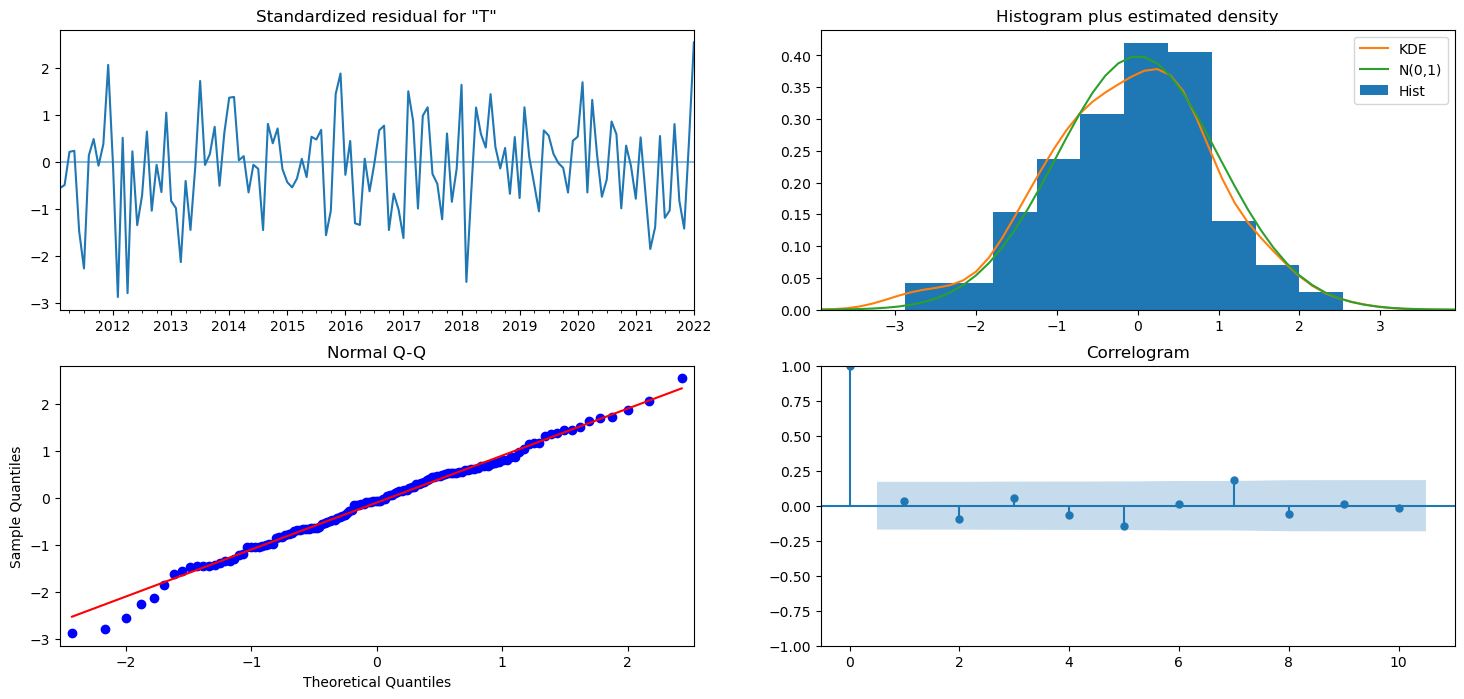

In [34]:
result_faster.plot_diagnostics(figsize=(18, 8))
plt.show()

From the diagnostic, our major concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean.

From the histogram, KDE and N(0,1) are close which indicate that residuals are normally distributed.

Moreover, the ditribution of residuals follow the linear trend of the smaple taken from N(0,1) in the Normal Q-Q graph. 

The diagnostic leads us to conclude that our model produces a satisfactory fit that could help us forecast future values.

In [35]:
result_faster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Temperature   No. Observations:                  145
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -269.665
Date:                            Fri, 04 Mar 2022   AIC                            547.330
Time:                                    07:37:58   BIC                            558.861
Sample:                                01-31-2010   HQIC                           552.015
                                     - 01-31-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1844      0.101      1.829      0.067      -0.013       0.382
ma.L1         -1.0000   3.21e+05  -3.11e-06      1.000   -6.29e+05    6.29e+05
ma.S.L12      -0.9777      1.167     -0.838      0.402      -3.265       1.310
sigma2         2.6650   8.56e+05   3.11e-06      1.000   -1.68e+06    1.68e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 0.91
Prob(Q):                              0.71   Prob(JB):                         0.63
Heteroskedasticity (H):               0.66   Skew:                            -0.19
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**According to the model summary, we have a very low standard deviation errors**

Now we will plot the graph:

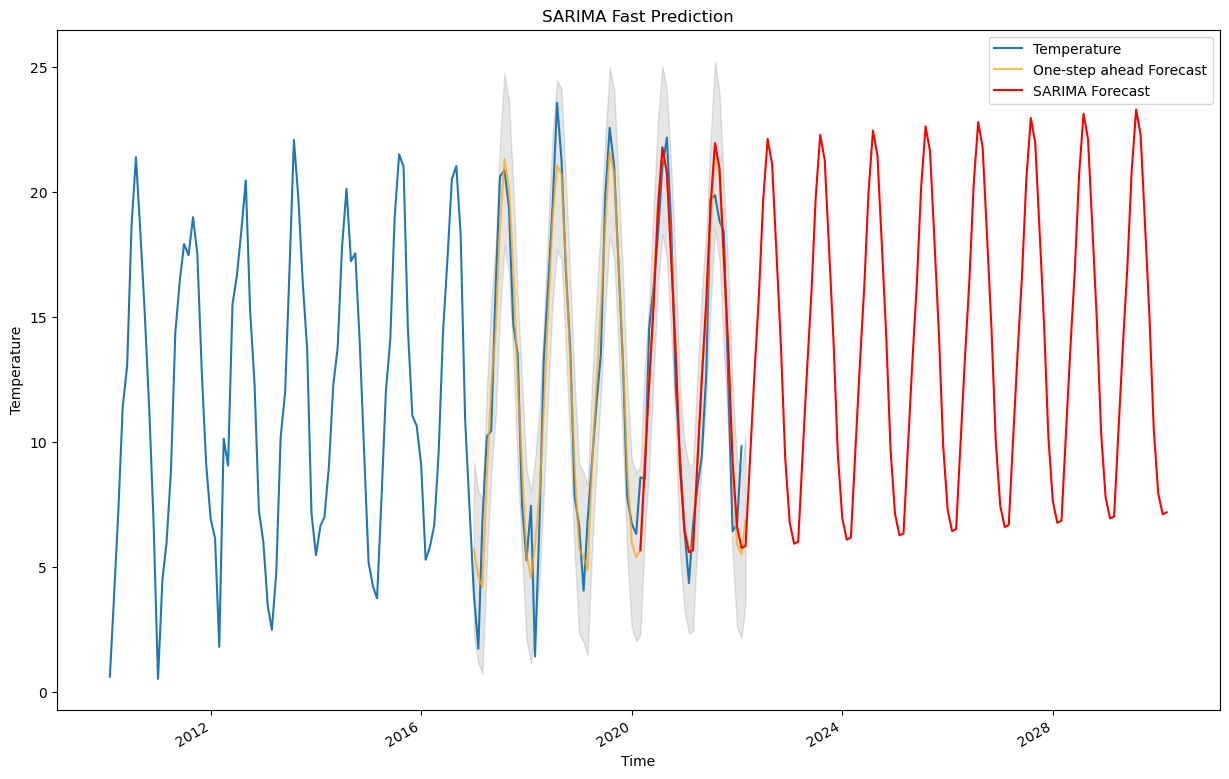

In [36]:
forecast_sarimax_monthly=result_faster.predict(start=len(data_temp_month)-period_length_month*2,end=len(data_temp_month)+period_length_month*8,dynamic=True)
pred=result_faster.get_prediction(start=('2016-12-31'),end=len(data_temp_month),dynamic=False)
pred_ci = pred.conf_int()
ax = data_temp_month.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.7, figsize=(15,10), color='orange')
plt.plot(forecast_sarimax_monthly,color = 'Red',label = 'SARIMA Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend(loc='best')
plt.title('SARIMA Fast Prediction')
plt.show()

We can see according to the graph and the summary results, we have an accurate forecasting model that can replicate the seasonality of the data across the future years. A few observations could be made thanks to the visualisation, 
* Even with the decrease since 2019, it seems like the model is predicting an increase over the next years
* 2021 seems to be a "colder" year compare to the others, a possible explination could be Covid-19 and the decrease in humain activites

In [37]:
def fit_predictions(model, steps_out_to_predict, actual_temperature):
    predicted_values = model.get_forecast(steps=steps_out_to_predict)
    mean_predicted_values = predicted_values.predicted_mean
    confidence_interval_predicted_values = predicted_values.conf_int()
    #Compare the actual to the predicted values using RMSE and MAE metrics
    rmse, mae = rmse_mae(mean_predicted_values, actual_temperature)
    print("Root mean squared error: ", str(rmse))
    print("Mean absolute error: ", str(mae))
    return mean_predicted_values, confidence_interval_predicted_values

#Calculate the mean absolute error of the model 
def rmse_mae(predicted_values, actual_temperature):
    rmse = math.sqrt(mean_squared_error(actual_temperature, predicted_values))
    mae = mean_absolute_error(actual_temperature, predicted_values)
    return rmse, mae
  
#Run the data on the test set to gauge model performance
mean_predicted_values, confidence_interval_predicted_values = fit_predictions(result_faster, 
                                                                              len(test_set), 
                                                                              test_set)

Root mean squared error:  3.7059880601162396
Mean absolute error:  3.0944281904491295


## 4.4 Facebook Prophet Model  
Prophet is a open-source time-series forecasting library introduced by Facebook for Univariate forecasting. Prophet is a type of Addtitive Time Series Model which is a non parametric regression model and it supports seasonality, trends, and holidays. By using Prophet, we hope to understand if our SARIMA model is correct and predicts well. 

Unlike Models like ARIMA, SARIMA, Prophet is designed to be completely automatic and simple to use.


Firstly, we need to reset the index and rename the columns to ds (dates) and y (values). Otherwise prophet will give us an error.

In [38]:
data_temp_prophet = data_temp.reset_index()
data_temp_prophet.head()

,index,Temperature
0,2010-01-01,-0.0625
1,2010-01-02,-0.6250
2,2010-01-03,-0.4875
3,2010-01-04,-4.6750
4,2010-01-05,-4.0625


In [39]:
#renaming columns
data_temp_prophet = data_temp_prophet.rename(columns={'index': 'ds', 'Temperature': 'y'})
data_temp_prophet.head()

,ds,y
0,2010-01-01,-0.0625
1,2010-01-02,-0.6250
2,2010-01-03,-0.4875
3,2010-01-04,-4.6750
4,2010-01-05,-4.0625


In [40]:
data_temp_prophet['ds'] = pd.to_datetime(data_temp_prophet['ds'])
data_temp_prophet

,ds,y
0,2010-01-01,-0.0625
1,2010-01-02,-0.6250
2,2010-01-03,-0.4875
3,2010-01-04,-4.6750
4,2010-01-05,-4.0625
...,...,...
4379,2021-12-28,11.2625
4380,2021-12-29,11.9500
4381,2021-12-30,13.3750
4382,2021-12-31,10.6250


In [41]:
# Initialize the Model
prophet_model=Prophet()
prophet_model.fit(data_temp_prophet) #if you want to fit again rerun model initialization cell

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [42]:
prophet_model.component_modes

{'additive': ['yearly',
  'weekly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

We see that prophet has already figured out that the data was yearly seasonal and additive.

In [43]:
# Create future dates of 365 days twice to have two years of forecast.
future_temperature=prophet_model.make_future_dataframe(periods=365*2)

In [44]:
future_temperature.tail()

,ds
5109,2023-12-28
5110,2023-12-29
5111,2023-12-30
5112,2023-12-31
5113,2024-01-01


In [45]:
#Forecasting
prediction=prophet_model.predict(future_temperature)

In [46]:
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-01,10.926628,0.532320,8.722391,10.926628,10.926628,-6.164271,-6.164271,-6.164271,0.125445,0.125445,0.125445,-6.289716,-6.289716,-6.289716,0.0,0.0,0.0,4.762357
1,2010-01-02,10.928195,0.581846,8.953345,10.928195,10.928195,-6.367413,-6.367413,-6.367413,0.041648,0.041648,0.041648,-6.409061,-6.409061,-6.409061,0.0,0.0,0.0,4.560783
2,2010-01-03,10.929762,0.453267,8.686785,10.929762,10.929762,-6.573250,-6.573250,-6.573250,-0.036722,-0.036722,-0.036722,-6.536528,-6.536528,-6.536528,0.0,0.0,0.0,4.356512
3,2010-01-04,10.931329,0.217449,8.199622,10.931329,10.931329,-6.779272,-6.779272,-6.779272,-0.109329,-0.109329,-0.109329,-6.669942,-6.669942,-6.669942,0.0,0.0,0.0,4.152058
4,2010-01-05,10.932896,-0.038384,7.936942,10.932896,10.932896,-6.958351,-6.958351,-6.958351,-0.151288,-0.151288,-0.151288,-6.807063,-6.807063,-6.807063,0.0,0.0,0.0,3.974545


yhat is the predicted value, upper and lower refers to the confident intervals of the predicted values. We will only focus on the yhat values for our predictions. 

Figure(1000x600)


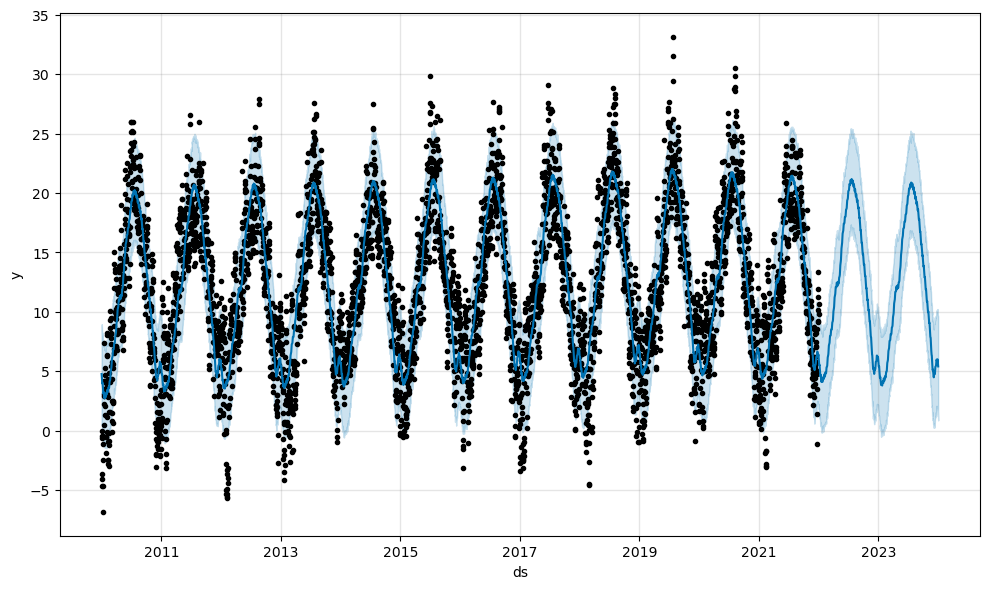

In [47]:
print(prophet_model.plot(prediction))
plt.show()

Here, the blue line refers to the predicted (yhat) values and light blue shade is the confidence interval. The black dots refer to the real historical data.

The historical data is mostly within the confident interval and the model seems to struggle to anticipate max and min values.

### 4.4.a Individual components
The benefit of using prophet is plotting the individual components as well such as trends, weekly, monthly projections.

Figure(900x900)


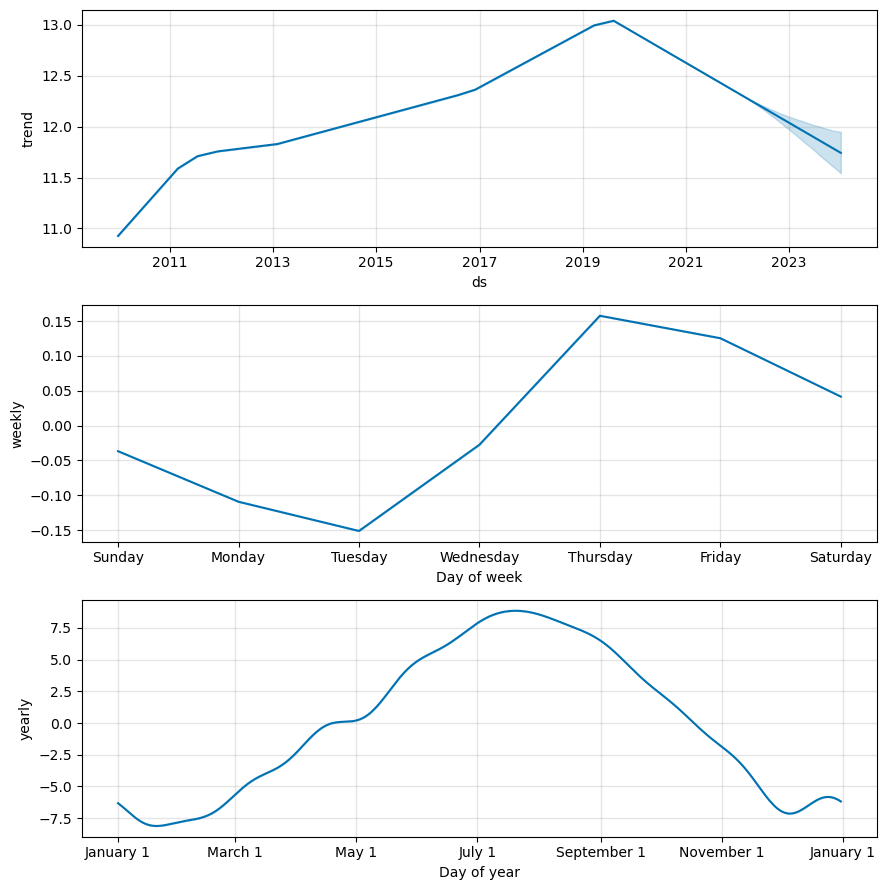

In [48]:
#Plotting the components
print(prophet_model.plot_components(prediction))
plt.show()

With above graphs, we can get more information than the SARIMAX Model. 
According to the trend in the data, we can see a increase in temperature in 2019 and a decrease the following years.
More importantly, due to seasonal temperature changes, the temperature increases from March to July and drops at the start of September.

While visualisation help us have a vague understanding of the predictions, we will analyse the prediction's accuracy with metrics built in the prophet model with cross-validation.

### 4.4.b Cross validation

Horizon is the period which the prediction performance is analyzed. The number of days that are determines the training period. I will set the training period to 3 years (1095 days). This will make predictions every period (180 days) which should be close to a third of the horizon. Since the data season is yearly, we can set the horizon to 1 year (365 days).

In [49]:
df_cv = cross_validation(prophet_model, initial='1095 days', period='180days', horizon = '365 days')
df_cv.head()

INFO:prophet:Making 17 forecasts with cutoffs between 2013-02-12 00:00:00 and 2021-01-01 00:00:00


  0%|          | 0/17 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-02-13,3.486933,-0.546150,7.400343,-0.0625,2013-02-12
1,2013-02-14,4.119155,0.193006,8.533907,1.4500,2013-02-12
2,2013-02-15,4.086514,0.038311,7.962287,5.1125,2013-02-12
3,2013-02-16,4.192201,-0.273788,8.281006,3.7250,2013-02-12
4,2013-02-17,4.136560,0.108331,8.350861,2.3500,2013-02-12


Here, yhat means the predicted value and yhat_lower and yhat_upper corrosponds to the confidence boundries. y refers to the real value. Next, we will use performance metrics such as Mean squared error (mse), mean absolute error (mae), root mse, between y and yhat to determine the accuracy

In [50]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,12.495917,3.534956,2.853180,0.982747,0.216811,0.399063,0.761575
1,38 days,12.482702,3.533087,2.850838,0.934914,0.212322,0.394845,0.762239
2,39 days,12.546852,3.542154,2.853766,1.684976,0.202418,0.394214,0.758159
3,40 days,12.828129,3.581638,2.876724,1.677912,0.202812,0.395138,0.752562
4,41 days,13.044704,3.611745,2.898618,1.673952,0.214215,0.396977,0.753416
...,...,...,...,...,...,...,...,...
324,361 days,14.018012,3.744064,3.043413,1.260603,0.206859,0.402463,0.738140
325,362 days,13.993872,3.740838,3.042991,1.242483,0.206859,0.405344,0.733966
326,363 days,13.971010,3.737781,3.032187,1.249523,0.206286,0.408020,0.730930
327,364 days,13.907608,3.729291,3.018144,1.253704,0.205064,0.410214,0.732448


We observe pretty low mse, rmse, and mae for the model.

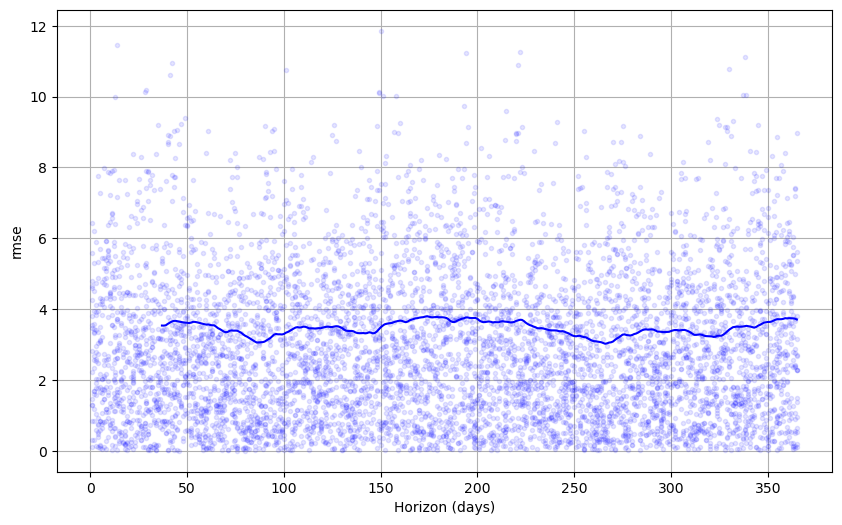

In [51]:
#visualizing  root mean square error
fig = plot_cross_validation_metric(df_cv, metric='rmse')
plt.show()

In above plot, we can see the rmse is pretty low (within 4 degrees) throughout the year (period).

## Comparing all ARIMA, SARIMA, with Prophet  
Since we created SARIMA with respect to the montly average (daily average calculation takes forever), we will convert ARIMA and Prophet according to the monthly average as well

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds          y
140  2021-09-30  18.399583
141  2021-10-31  12.256855
142  2021-11-30   6.443333
143  2021-12-31   6.718293
144  2022-01-31   9.837500
             ds
3060 2030-01-25
3061 2030-01-26
3062 2030-01-27
3063 2030-01-28
3064 2030-01-29


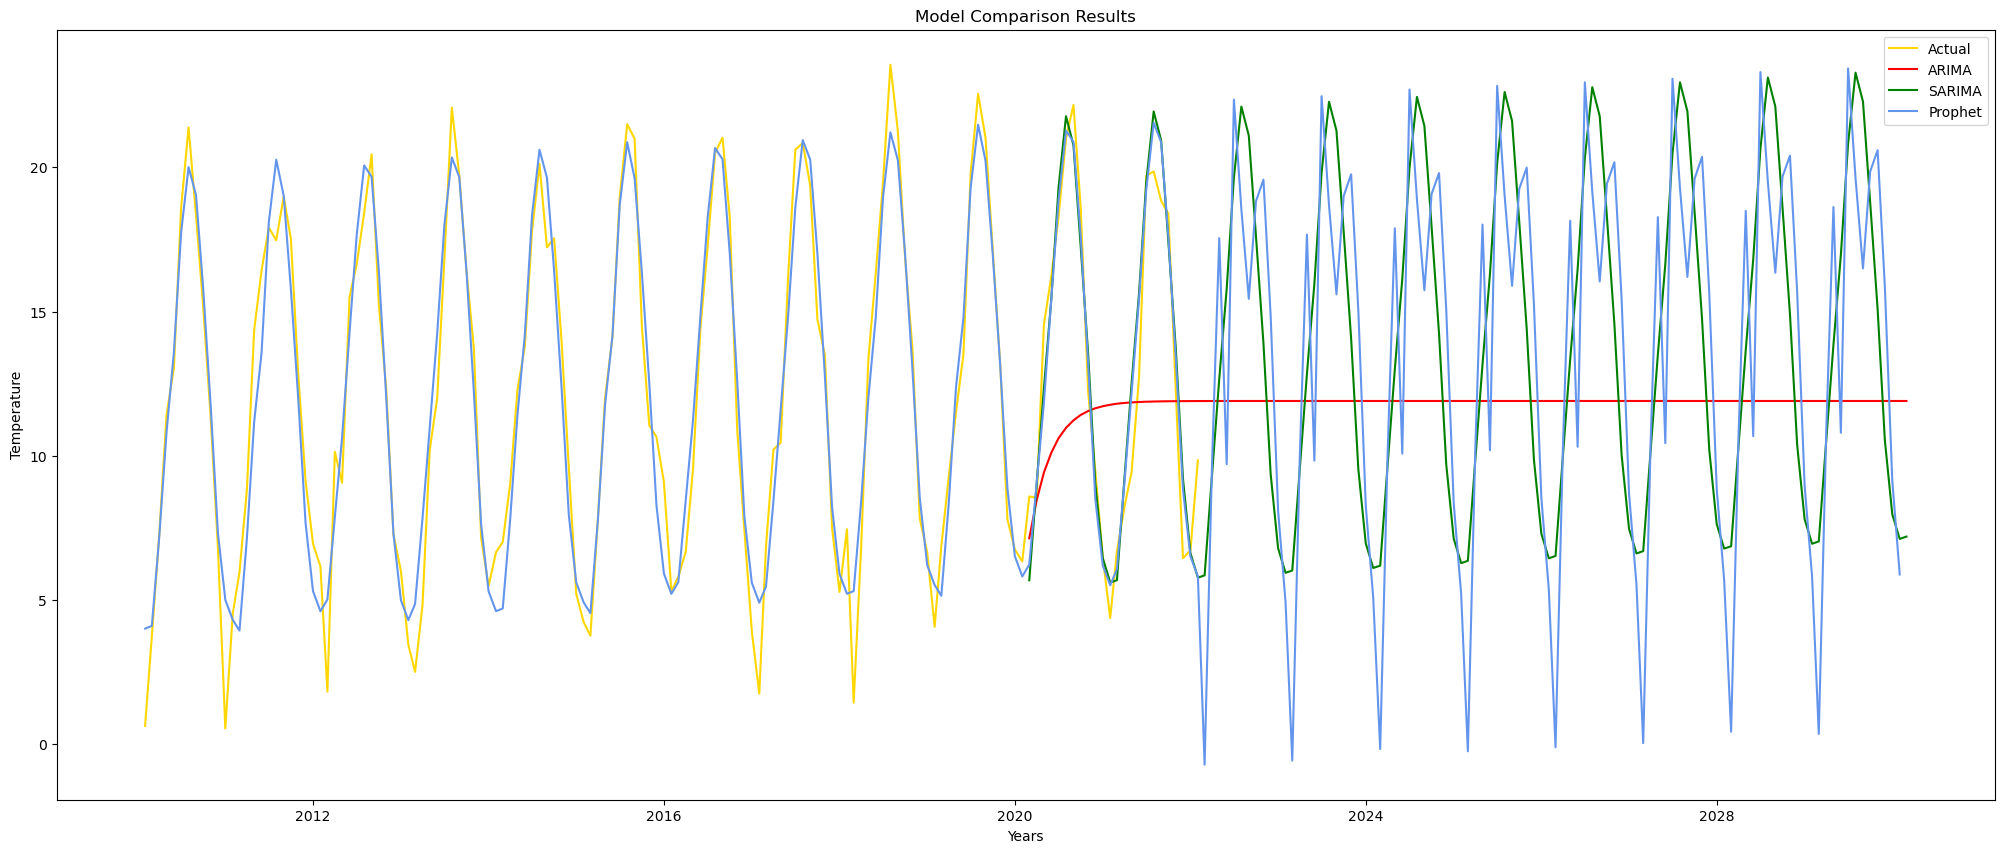

In [52]:
model_monthly=ARIMA(data_temp_month['Temperature'],order=(1,0,1))
model_fit_monthly=model_monthly.fit()
forecast_monthly=model_fit_monthly.predict(start=len(data_temp_month)-period_length_month*2,end=len(data_temp_month)+period_length_month*8,dynamic=True)

# Initialize the Model
prophet_model_monthly=Prophet()

data_temp_prophet_monthly = data_temp_month.reset_index()
data_temp_prophet_monthly =  data_temp_prophet_monthly.rename(columns={'index': 'ds', 'Temperature': 'y'})
print(data_temp_prophet_monthly.tail())


prophet_model_monthly.fit(data_temp_prophet_monthly) #if you want to fit again rerun model initialization cell
### Create future dates of 2 years
future_temperature_monthly=prophet_model_monthly.make_future_dataframe(periods=365*8)# so we can have two years of forecast
prediction_monthly=prophet_model_monthly.predict(future_temperature_monthly)
print(future_temperature_monthly.tail())
future_temperature_monthly['yhat'] = prediction_monthly['yhat']
future_temperature_monthly.set_index('ds',inplace = True)

#Because prophet model outputs daily values for the predicted future years, we need to resample data dataset to make it only 
#available monthly.
future_temperature_monthly = future_temperature_monthly.resample('M').mean()

plt.figure(figsize=(25,10))
plt.plot(data_temp_month,color = 'gold',label = 'Actual') #makes things easier
plt.plot(forecast_monthly,color = 'Red',label = 'ARIMA')
plt.plot(forecast_sarimax_monthly,color = 'Green',label = 'SARIMA')
plt.plot(future_temperature_monthly['yhat'],color = '#6495ed',label = 'Prophet')
plt.xlabel('Years')
plt.ylabel('Temperature')
plt.legend(loc='best')
plt.title('Model Comparison Results')
plt.show()

## Conclusion  
As expected, ARIMA Model performs poorly. Both SARIMA and prophet models are predicting future temperatures really well. There are some unexplained noise in the prophet model, this maybe due to it accounting for monthly changes (differently than SARIMA).
We can also see that for past values, Prophet model does a pretty good job. Although it fails to capture extreme values in the temperature.  

  
We found with the two models that there is a noticable increase in average temperature throughout the years.

## References

Aggarwal, P. (2020). Time Series Analysis. [Available at](https://github.com/aggpranshu53/MLAlgorithms/blob/master/Time%20Series%20Analysis.ipynb) 

Anderson, A. and Semmelroth, D., 2016. dummies - Learning Made Easy. [online] Dummies.com. [Available at](https://www.dummies.com/article/technology/information-technology/data-science/big-data/autocorrelation-plots-graphical-technique-for-statistical-data-141241)

Akshay, J., 2022. ARIMA & SARIMA: Real-World Time Series Forecasting (Guide) - neptune.ai. [online] neptune.ai. [Available at](https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide)

Brownlee, J. (2018). Deep learning for time series forecasting: predict the future with MLPs, CNNs and LSTMs in Python. Machine Learning Mastery. [Available at](https://books.google.co.uk/books?hl=fr&lr=&id=o5qnDwAAQBAJ&oi=fnd&pg=PP1&dq=Deep+Learning+for+Time+Series+Forecasting+Predict+the+Future+with+MLPs,+CNNs+and+LSTMs+in+Python&ots=yH37tKpa8a&sig=Wd30jjstDOQU8gQk1F6KoqYbr34&redir_esc=y#v=onepage&q=Deep%20Learning%20for%20Time%20Series%20Forecasting%20Predict%20the%20Future%20with%20MLPs%2C%20CNNs%20and%20LSTMs%20in%20Python&f=false) 

Brownlee, J. (2019). Machine learning mastery with Weka. Ebook. Edition, 1(4). [Available at](https://machinelearningmastery.com/category/time-series/)

Prabhakaran, S., 2019. Augmented Dickey-Fuller (ADF) Test - Must Read Guide - ML+. [online] Machine Learning Plus. [Available at](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/) 

Shao, V. (2020). Time Series Prediction [Available at](https://github.com/Bounteous-Inc/Time-Series-Prediction)

Vincent, T., 2017. A Guide to Time Series Forecasting with ARIMA in Python 3 | DigitalOcean. [online] Digitalocean.com. [Available at](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3)

Wang, Z., Li, P., Li, L., Huang, C., & Liu, M. (2015). Modeling and forecasting average temperature for weather derivative pricing. Advances in Meteorology, 2015. [Available at](https://www.hindawi.com/journals/amete/2015/837293/)

In [53]:
#Word count
with io.open("Weather_forecasting_Time_Series.ipynb", 'r', encoding='utf-8') as f:
        nb = current.read(f, 'json')

  
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print('Word count including titles and references:',word_count)

Word count including titles and references: 2380
